Implementing Recommender System

In [1]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
import pandas as pd
tb_final = pd.read_csv('/content/drive/My Drive/tb_final.csv')

In [0]:
tb_final.head()

,user_id,item_id,category_id,behavior_type,timestamp,date
0,3777,4695412,2562909,pv,2017-12-01 01:31:12,01/12/2017
1,3777,1934018,2562909,pv,2017-12-01 01:27:58,01/12/2017
2,3777,2737791,2562909,pv,2017-12-01 01:26:19,01/12/2017
3,3777,1518674,2562909,pv,2017-12-01 01:24:49,01/12/2017
4,3777,310572,1376358,pv,2017-12-01 00:54:15,01/12/2017


In [0]:
tb_final.behavior_type.unique()

array(['pv', 'buy', 'cart', 'fav'], dtype=object)

In [0]:
#Group together with user_id, item_id, category_id and behavior type
grouped_tb = tb_final[['user_id', 'item_id', 'category_id', 'behavior_type']]

In [0]:
grouped_tb.head()

,user_id,item_id,category_id,behavior_type
0,1,46259,149192,pv
1,1,2087357,2131531,pv
2,1,4152983,2355072,pv
3,1,4170517,149192,pv
4,1,1340922,4690421,pv


In [4]:
# convert user id, item id and category id into numeric

grouped_tb['user'] = grouped_tb['user_id'].astype("category").cat.codes
grouped_tb['item'] = grouped_tb['item_id'].astype("category").cat.codes
grouped_tb['category'] = grouped_tb['category_id'].astype("category").cat.codes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
grouped_tb.head()

,user_id,item_id,category_id,behavior_type,user,item,category
0,1,46259,149192,pv,0,2028,137
1,1,2087357,2131531,pv,0,94354,1995
2,1,4152983,2355072,pv,0,188350,2198
3,1,4170517,149192,pv,0,189116,137
4,1,1340922,4690421,pv,0,60548,4458


In [0]:
#Total number of items
len(grouped_tb['item'].unique())

234096

In [0]:
#Total number of categories
len(grouped_tb['category'].unique())

4895

In [0]:
#Total number of users
len(grouped_tb['user'].unique())

4831

In [0]:
#Split grouped_tb into 4 dataframes based on the behavior type.
tb_pv = grouped_tb[grouped_tb['behavior_type']=='pv']
tb_fav = grouped_tb[grouped_tb['behavior_type']=='fav']
tb_cart = grouped_tb[grouped_tb['behavior_type']=='cart']
tb_buy = grouped_tb[grouped_tb['behavior_type']=='buy']

Recommender for new users: Top items based on popularity

Recommender for existing users: Alternating Least Squares Method

In [6]:
!pip install implicit

     |████████████████████████████████| 1.1MB 2.9MB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3471580 sha256=2f987a4bee67fdb53f7de5bf3ed29030dd32eedec39a03c7f75d38b6434a8d69
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [0]:
import scipy.sparse as sparse
import numpy as np
import implicit

Recommend based on Page Views

In [0]:
pv_count = tb_pv.groupby(['user', 'item', 'category']).size().reset_index(name='counts')

In [0]:
pv_count.head()

,user,item,category,counts
0,0,2028,137,2
1,0,3570,2198,1
2,0,10413,413,1
3,0,12003,2349,2
4,0,12213,413,1


In [0]:
#Create two matrices:
#Matrix 1: model fitting (item-user) 
#Matrix 2: recommendation (user-item)

#Behavior type = pv
sparse_item_user_pv = sparse.csr_matrix((pv_count['counts'].astype(float), (pv_count['item'], pv_count['user'])))
sparse_user_item_pv = sparse.csr_matrix((pv_count['counts'].astype(float), (pv_count['user'], pv_count['item'])))


In [10]:
#Alternating Least Squares Method
model_pv = implicit.als.AlternatingLeastSquares(factors=32, regularization=0.1, iterations=10, use_gpu=True)

In [11]:
#Calculate the confidence for each value in our data
#Alpha value between 15 and 40 is advisable. Ref: https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe
alpha = 20
data_pv = (sparse_item_user_pv * alpha).astype('double')
model_pv.fit(data_pv)

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
def recommend(df, user, sparse_user_item, user_vecs, item_vecs, num_items=10):

  #Recommender for new users
  if user not in df['user'].unique():
    df_pop = df.groupby(['item', 'category']).size().reset_index(name='counts')
    df_pop.sort_values(by='counts', ascending=False, inplace=True)
    df_pop.columns = ['Item ID', 'Category ID', 'Counts']
    df_pop.reset_index(drop=True, inplace=True)
    print("Top picks for new user:", '\n\n', df_pop[:10])
    return('\n')

  #Recommender for existing users
  else:
    #Interactions scores from the sparse user-item matrix
    user_interactions = sparse_user_item[user,:].toarray()
   
    # We don't want to recommend items the user has interacted with. 
    # Set user interactions for these to be 0 and unknowns to 1.
    
    user_interactions = user_interactions.reshape(-1) + 1

    user_interactions[user_interactions > 1] = 0

    #Dot product of user vector and all item vectors
    rec_vector = user_vecs[user,:].dot(item_vecs.T).toarray()
    
    #Scale the recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    
    # Multiply the recommendation of those item already interacted by zero 
    recommend_vector = user_interactions * rec_vector_scaled

    # Sort the indices of the items by order of recommendation
    item_index = np.argsort(recommend_vector)[::-1][:num_items]
    
    # Store item IDs, category IDs and scores
    items = []
    categories =[]
    scores = []

    # Recommendation score = Ui.VT. A higher value of the dot product means more confidence in the prediction of an item for a particular user.
    for index in item_index:
        items.append(grouped_tb.item.loc[grouped_tb.item == index].iloc[0])
        scores.append(recommend_vector[index])
        categories.append(grouped_tb.category.loc[grouped_tb.item == index].iloc[0])

    recommendations = pd.DataFrame({'Item ID': items, 'Category ID': categories,'Score': scores})
    print("Top picks for existing user:", '\n\n', recommendations)
    return('\n')

In [0]:
# Get the trained user and item vectors. Convert to csr_matrix.
user_vecs_pv = sparse.csr_matrix(model_pv.user_factors)
item_vecs_pv = sparse.csr_matrix(model_pv.item_factors)

In [0]:
# Example: Create recommendations for existing user with id 1 
# View the top 10 scores with their respective Item IDs and Category IDs

user = 1

recommendations = recommend(pv_count, user, sparse_user_item_pv, user_vecs_pv, item_vecs_pv)

print(recommendations)

Top picks for existing user: 

    Item ID  Category ID     Score
0    80241         1958  1.000000
1    98034         1958  0.898912
2    97594         4567  0.896049
3    69628          922  0.888135
4    59568         1958  0.835949
5   181250         1958  0.831107
6    68656         4009  0.822174
7    15855         2718  0.811397
8   129204         4520  0.808031
9   200363         1958  0.806828




In [0]:
grouped_tb.loc[grouped_tb['item']==80241]

,user_id,item_id,category_id,behavior_type,user,item,category
12764,99,1773536,2096639,pv,90,80241,1958
62846,1556,1773536,2096639,pv,1508,80241,1958
62859,1556,1773536,2096639,pv,1508,80241,1958
62864,1556,1773536,2096639,pv,1508,80241,1958
62867,1556,1773536,2096639,pv,1508,80241,1958
66557,213,1773536,2096639,pv,198,80241,1958
66563,213,1773536,2096639,pv,198,80241,1958
71251,138,1773536,2096639,pv,128,80241,1958
71253,138,1773536,2096639,pv,128,80241,1958
73082,1306,1773536,2096639,pv,1264,80241,1958


In [15]:
# Example: Create recommendations for new user with id 12345 
# View the top 10 scores with their respective Item IDs and Category IDs

user = 12345

recommendations = recommend(pv_count, user, sparse_user_item_pv, user_vecs_pv, item_vecs_pv)

print(recommendations)

Top picks for new user: 

    Item ID  Category ID  Counts
0    36599         4520      93
1   174403         3415      85
2   105408         3415      82
3     2684         4582      82
4   105712         3415      81
5   137441         2578      77
6   152687         1726      73
7   110908         3461      72
8    69322         3670      71
9   107022         1726      70




Recommend based on saved favorites.

In [0]:
fav_count = tb_fav.groupby(['user', 'item', 'category']).size().reset_index(name='counts')

In [0]:
fav_count.head()

,user,item,category,counts
0,1,5016,3915,1
1,1,8215,4452,1
2,1,29957,888,1
3,1,131380,3676,1
4,1,166380,877,1


In [0]:
#Create two matrices:
#Matrix 1: model fitting (item-user) 
#Matrix 2: recommendation (user-item)

#Behavior type = fav
sparse_item_user_fav = sparse.csr_matrix((fav_count['counts'].astype(float), (fav_count['item'], fav_count['user'])))
sparse_user_item_fav = sparse.csr_matrix((fav_count['counts'].astype(float), (fav_count['user'], fav_count['item'])))

In [0]:
#Alternating Least Squares Method
model_fav = implicit.als.AlternatingLeastSquares(factors=32, regularization=0.1, iterations=10, use_gpu=True)

In [19]:
#Calculate the confidence for each value in our data
#Alpha value between 15 and 40 is advisable. Ref: https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe
alpha = 20
data_fav = (sparse_item_user_fav * alpha).astype('double')
model_fav.fit(data_fav)

In [0]:
# Get the trained user and item vectors. Convert to csr_matrix.
user_vecs_fav = sparse.csr_matrix(model_fav.user_factors)
item_vecs_fav = sparse.csr_matrix(model_fav.item_factors)

In [21]:
# Example: Create recommendations for user with id 1 
# View the top 10 scores with their respective Item IDs and Category IDs

user = 1

fav_recommendations = recommend(fav_count, user, sparse_user_item_fav, user_vecs_fav, item_vecs_fav)

print(fav_recommendations)

Top picks for existing user: 

    Item ID  Category ID     Score
0   164289         3931  0.880549
1    90473         1012  0.827924
2   170079         2750  0.817587
3   115188         4663  0.808128
4    85531          830  0.798927
5    82465         4567  0.796747
6    98363         4520  0.775304
7     9134         2198  0.767794
8    81160         4520  0.758271
9   117620         2578  0.754835




In [22]:
# Example: Create recommendations for new user with id 12345 
# View the top 10 scores with their respective Item IDs and Category IDs

user = 12345

recommendations = recommend(fav_count, user, sparse_user_item_fav, user_vecs_fav, item_vecs_fav)

print(recommendations)

Top picks for new user: 

    Item ID  Category ID  Counts
0    69322         3670       6
1   154169         3415       6
2   106844         4520       5
3   105408         3415       5
4    80717         1879       4
5    29078         2293       4
6    45025         3120       4
7   159080         4567       4
8   105712         3415       4
9    76183         2578       4




Recommend based on Add to Cart items.

In [0]:
cart_count = tb_cart.groupby(['user', 'item', 'category']).size().reset_index(name='counts')

In [0]:
cart_count.head()

,user,item,category,counts
0,1,59879,3995,1
1,1,78622,3995,1
2,1,139163,1273,1
3,2,3932,2415,1
4,2,11505,852,1


In [0]:
#Create two matrices:
#Matrix 1: model fitting (item-user) 
#Matrix 2: recommendation (user-item)

#Behavior type = cart
sparse_item_user_cart = sparse.csr_matrix((cart_count['counts'].astype(float), (cart_count['item'], cart_count['user'])))
sparse_user_item_cart = sparse.csr_matrix((cart_count['counts'].astype(float), (cart_count['user'], cart_count['item'])))

In [0]:
#Alternating Least Squares Method
model_cart = implicit.als.AlternatingLeastSquares(factors=32, regularization=0.1, iterations=10, use_gpu=True)

In [26]:
#Calculate the confidence for each value in our data
#Alpha value between 15 and 40 is advisable. Ref: https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe
alpha = 20
data_cart = (sparse_item_user_cart * alpha).astype('double')
model_cart.fit(data_cart)

In [0]:
# Get the trained user and item vectors. Convert to csr_matrix.
user_vecs_cart = sparse.csr_matrix(model_cart.user_factors)
item_vecs_cart = sparse.csr_matrix(model_cart.item_factors)

In [28]:
# Example: Create recommendations for user with id 1 
# View the top 10 scores with their respective Item IDs and Category IDs

user = 1

cart_recommendations = recommend(cart_count, user, sparse_user_item_cart, user_vecs_cart, item_vecs_cart)

print(cart_recommendations)

Top picks for existing user: 

    Item ID  Category ID     Score
0   117620         2578  1.000000
1   131320         4567  0.902388
2    70551         2578  0.869136
3   225488         3534  0.855757
4   112432         3534  0.854635
5   231606         3931  0.853496
6   114500         2578  0.850961
7   221020         4520  0.849989
8    23010         3415  0.848311
9    84408         4420  0.838837




In [29]:
# Example: Create recommendations for new user with id 12345 
# View the top 10 scores with their respective Item IDs and Category IDs

user = 12345

recommendations = recommend(cart_count, user, sparse_user_item_cart, user_vecs_cart, item_vecs_cart)

print(recommendations)

Top picks for new user: 

    Item ID  Category ID  Counts
0   115747         2578      10
1   137441         2578      10
2    16452         2578       9
3    71531         4567       9
4   105408         3415       8
5   210676         4520       8
6    65171         2578       8
7    36599         4520       8
8    63280          922       7
9   124130         3534       7




Recommend based on user purchases.

In [0]:
buy_count = tb_buy.groupby(['user', 'item', 'category']).size().reset_index(name='counts')

In [0]:
buy_count.head()

,user,item,category,counts
0,1,48154,3266,1
1,1,52427,2762,1
2,1,64941,3943,1
3,1,146258,3943,1
4,1,158319,2718,1


In [0]:
#Create two matrices:
#Matrix 1: model fitting (item-user) 
#Matrix 2: recommendation (user-item)

#Behavior type = buy
sparse_item_user_buy = sparse.csr_matrix((buy_count['counts'].astype(float), (buy_count['item'], buy_count['user'])))
sparse_user_item_buy = sparse.csr_matrix((buy_count['counts'].astype(float), (buy_count['user'], buy_count['item'])))

In [0]:
#Alternating Least Squares Method
model_buy = implicit.als.AlternatingLeastSquares(factors=32, regularization=0.1, iterations=10, use_gpu=True)

In [33]:
#Calculate the confidence for each value in our data
#Alpha value between 15 and 40 is advisable. Ref: https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe
alpha = 20
data_buy = (sparse_item_user_buy * alpha).astype('double')
model_buy.fit(data_buy)

In [0]:
# Get the trained user and item vectors. Convert to csr_matrix.
user_vecs_buy = sparse.csr_matrix(model_buy.user_factors)
item_vecs_buy = sparse.csr_matrix(model_buy.item_factors)

In [35]:
# Example: Create recommendations for user with id 1 
# View the top 10 scores with their respective Item IDs and Category IDs

user = 1

buy_recommendations = recommend(buy_count, user, sparse_user_item_buy, user_vecs_buy, item_vecs_buy)

print(buy_recommendations)

Top picks for existing user: 

    Item ID  Category ID     Score
0    60279         1840  0.829447
1     6949         3083  0.810875
2   206048         1252  0.780378
3   100288         1662  0.767859
4   135298         4007  0.756388
5   129876         3715  0.756388
6   178020         3415  0.750500
7   213295         4088  0.734380
8   125207           45  0.729198
9   208636         4298  0.719375




In [36]:
# Example: Create recommendations for new user with id 12345 
# View the top 10 scores with their respective Item IDs and Category IDs

user = 12345

recommendations = recommend(buy_count, user, sparse_user_item_buy, user_vecs_buy, item_vecs_buy)

print(recommendations)

Top picks for new user: 

    Item ID  Category ID  Counts
0   141515         1427       7
1     3423         1791       5
2   137441         2578       5
3   142407         2326       4
4   115747         2578       4
5   208890         2612       4
6   133969         4678       4
7    47310         4557       4
8   134392         1178       4
9   120665         4359       4




Creating Telegram Bot Data 

In [0]:
#create function for telegram bot implementation

def bot(df, user, sparse_user_item, user_vecs, item_vecs, num_items=10):
#buy_count, user, sparse_user_item_pv, user_vecs_pv, item_vecs_pv

    #Interactions scores from the sparse user-item matrix
    user_interactions = sparse_user_item[user,:].toarray()
   
    # We don't want to recommend items the user has interacted with. 
    # Set user interactions for these to be 0 and unknowns to 1.
    
    user_interactions = user_interactions.reshape(-1) + 1

    user_interactions[user_interactions > 1] = 0

    #Dot product of user vector and all item vectors
    rec_vector = user_vecs[user,:].dot(item_vecs.T).toarray()
    
    #Scale the recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    
    # Multiply the recommendation of those item already interacted by zero 
    recommend_vector = user_interactions * rec_vector_scaled

    # Sort the indices of the items by order of recommendation
    item_index = np.argsort(recommend_vector)[::-1][:num_items]
    
    # Store item IDs
    items = []

    # Recommendation score = Ui.VT. A higher value of the dot product means more confidence in the prediction of an item for a particular user.
    for index in item_index:
        items.append(grouped_tb.item.loc[grouped_tb.item == index].iloc[0])

    bot_recommendations = pd.DataFrame({'User ID': user, 'Item ID': items})
    return bot_recommendations

In [62]:
df_bot_buy = pd.DataFrame()
for user in range(len(buy_count.user.unique())):
  df_bot_buy = df_bot_buy.append(bot(buy_count, user, sparse_user_item_buy, user_vecs_buy, item_vecs_buy))
  print(user)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [63]:
df_bot_cart = pd.DataFrame()
for user in range (len(cart_count.user.unique())):
  df_bot_cart = df_bot_cart.append(bot(cart_count, user, sparse_user_item_cart, user_vecs_cart, item_vecs_cart))
  print(user)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [64]:
df_bot_fav = pd.DataFrame()
for user in range (len(fav_count.user.unique())):
  df_bot_fav = df_bot_fav.append(bot(fav_count, user, sparse_user_item_fav, user_vecs_fav, item_vecs_fav))
  print(user)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [59]:
df_bot_pv = pd.DataFrame()
for user in range (len(pv_count.user.unique())):
  df_bot_pv = df_bot_pv.append(bot(pv_count, user, sparse_user_item_pv, user_vecs_pv, item_vecs_pv))
  print(user)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
df_bot_buy.to_csv('/content/drive/My Drive/dfbuy.csv', index=False)

In [0]:
df_bot_cart.to_csv('/content/drive/My Drive/dfcart.csv', index=False)

In [0]:
df_bot_fav.to_csv('/content/drive/My Drive/dffav.csv', index=False)

In [0]:
df_bot_pv.to_csv('/content/drive/My Drive/dfpv.csv', index=False)

Get the top 10 items user 1 has interacted with, to compare with the top 10 recommended products to user 1

In [0]:
buy_count.loc[buy_count['user'] == 1].sort_values(by=['counts'], ascending=False)[['user', 'item', 'category']].head(10)

,user,item,category
0,1,48154,3266
1,1,52427,2762
2,1,64941,3943
3,1,146258,3943
4,1,158319,2718
5,1,168989,2700
6,1,212071,1718


Evaluate Recommender System

In [0]:
#Ref: https://jessesw.com/Rec-System/
import random

def make_train(sparse_mtx, pct_test = 0.2):

#sparse_mtx
#he original matrix from which you want to generate a train/test set. Test is just a complete copy of the original set. This is in the form of a sparse csr_matrix. 

#pct_test:
#The percentage of user-item interactions where an interaction took place that you want to mask in the training set for later comparison to the test set, which contains all of the original ratings. 

    test_set = sparse_mtx.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    
    training_set = sparse_mtx.copy() # Make a copy of the original data we can alter as our training set. 
    
    nonzero_indices = training_set.nonzero() # Find the indices in the data where an interaction exists
    nonzero_pairs = list(zip(nonzero_indices[0], nonzero_indices[1])) # Zip item, user into list

    
    random.seed(42) # Set the random seed to 42 for reproducibility
    
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of item-user pairs without replacement

    item_indices = [index[0] for index in samples] # Get the item row indices

    user_indices = [index[1] for index in samples] # Get the user column indices

    
    training_set[item_indices, user_indices] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    
    return training_set, test_set, list(set(user_indices))

In [0]:
# for all behavior types
item_train_pv, item_test_pv, item_users_altered_pv = make_train(sparse_item_user_pv, pct_test = 0.2)

item_train_fav, item_test_fav, item_users_altered_fav = make_train(sparse_item_user_fav, pct_test = 0.2)

item_train_cart, item_test_cart, item_users_altered_cart = make_train(sparse_item_user_cart, pct_test = 0.2)

item_train_buy, item_test_buy, item_users_altered_buy = make_train(sparse_item_user_buy, pct_test = 0.2)

In [0]:
from sklearn import metrics

In [0]:
def auc_score(predictions, test):
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

In [0]:
def calc_mean_auc(training_set, altered_users, predictions, test_set, df):
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 1)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]

    count = 0

    for user in altered_users: # Iterate through each user that had an item altered
      if user in df.user.unique():
          training_column = training_set[:,user].toarray().reshape(-1) # Get the training set column
          zero_inds = np.where(training_column == 0) # Find where the interaction had not yet occurred
        
          # Get the predicted values based on our user/item vectors
          user_vec = predictions[0][user,:]
          pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        
          # Get only the items that were originally zero
          # Select all ratings from the MF prediction for this user that originally had no iteraction
          actual = test_set[:,user].toarray()[zero_inds,0].reshape(-1)
        
          # Select the binarized yes/no interaction pairs from the original full data
          # that align with the same pairs in training 
          pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        
          store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        
          popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and store
        
        
          if (count%100==0): #prints every 100th iteration to monitor progress of loading.
            print("Iteration:", count)
          count+=1
      # End users iteration

    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))

In [0]:
calc_mean_auc(item_train_pv, item_users_altered_pv,
              [user_vecs_pv, item_vecs_pv.T], item_test_pv, pv_count)

Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000
Iteration: 1100
Iteration: 1200
Iteration: 1300
Iteration: 1400
Iteration: 1500
Iteration: 1600
Iteration: 1700
Iteration: 1800
Iteration: 1900
Iteration: 2000
Iteration: 2100
Iteration: 2200
Iteration: 2300
Iteration: 2400
Iteration: 2500
Iteration: 2600
Iteration: 2700
Iteration: 2800
Iteration: 2900
Iteration: 3000
Iteration: 3100
Iteration: 3200
Iteration: 3300
Iteration: 3400
Iteration: 3500
Iteration: 3600
Iteration: 3700
Iteration: 3800
Iteration: 3900
Iteration: 4000
Iteration: 4100
Iteration: 4200
Iteration: 4300
Iteration: 4400
Iteration: 4500
Iteration: 4600
Iteration: 4700


(0.928, 0.666)

As a benchmark, I calculated the mean AUC for most popular items, to compare it with the recommender for top 10 items. My recommender system has a higher mean AUC score (0.929) vis-a-vis the benchmark recommender (0.666).

Recommender systems have a problem known as user cold-start, hence instead of providing personalized recommendations for users with no interactions on taobao, the top 10 most interacted items based on the different behavior types could be used as an initial recommendation for the new user.

In [0]:
calc_mean_auc(item_train_fav, item_users_altered_fav,
              [user_vecs_fav, item_vecs_fav.T], item_test_fav, fav_count)

Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000


(0.993, 0.973)

In [0]:
calc_mean_auc(item_train_cart, item_users_altered_cart,
              [user_vecs_cart, item_vecs_cart.T], item_test_cart, cart_count)

Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000
Iteration: 1100
Iteration: 1200
Iteration: 1300
Iteration: 1400
Iteration: 1500
Iteration: 1600
Iteration: 1700
Iteration: 1800
Iteration: 1900
Iteration: 2000
Iteration: 2100
Iteration: 2200
Iteration: 2300


(0.986, 0.951)

In [0]:
calc_mean_auc(item_train_buy, item_users_altered_buy,
              [user_vecs_buy, item_vecs_buy.T], item_test_buy, buy_count)

Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000
Iteration: 1100
Iteration: 1200
Iteration: 1300


(0.996, 0.983)

In [0]:
import matplotlib.pyplot as plt

In [0]:
def plot_roc(user, training_set, altered_users, predictions, test_set):
    item_vecs = predictions[1]
    
    if user in altered_users: 
      training_column = training_set[:,user].toarray().reshape(-1) 
      zero_inds = np.where(training_column == 0) 
      pop_items = np.array(test_set.sum(axis = 1)).reshape(-1)   
    
      user_vec = predictions[0][user,:]
      pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
      actual = test_set[:,user].toarray()[zero_inds,0].reshape(-1)
      pop = pop_items[zero_inds]

    # Define true positive rate and false positive rate.
      fpr, tpr, thresholds = metrics.roc_curve(actual, pred)
      fpr_pop, tpr_pop, thresholds_pop = metrics.roc_curve(actual, pop)

    # Plot ROC.
      plt.plot(fpr, tpr, label='ROC Curve')

    # Plot baseline. 
      #plt.plot(np.linspace(0, 1, 200),  np.linspace(0, 1, 200), label='baseline', linestyle='--')
      plt.plot (fpr_pop, tpr_pop, label='Baseline', linestyle = '--')

    # Label axes.
      plt.title('Receiver Operating Characteristic Curve for User '+str(user), fontsize=18)
      plt.ylabel('Sensitivity', fontsize=14)
      plt.xlabel('1 - Specificity', fontsize=14)

    # Create legend.
      plt.legend(fontsize=14);

    return plt.show()

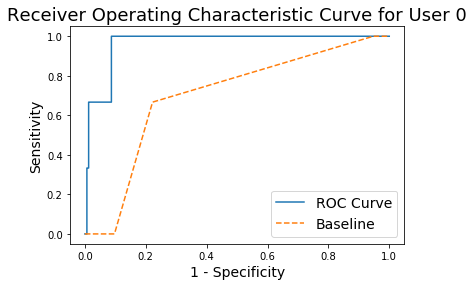

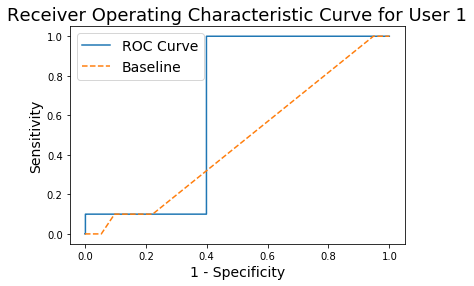

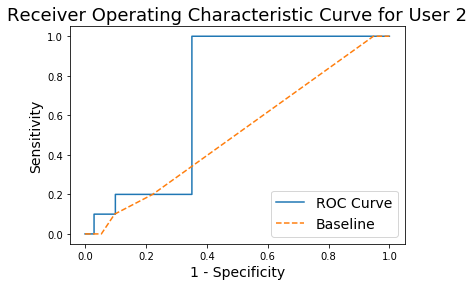

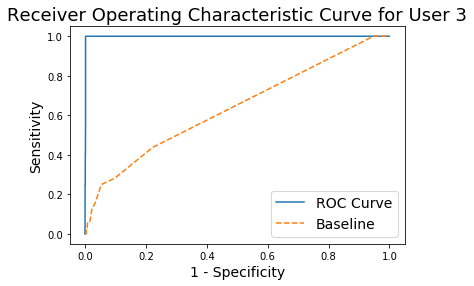

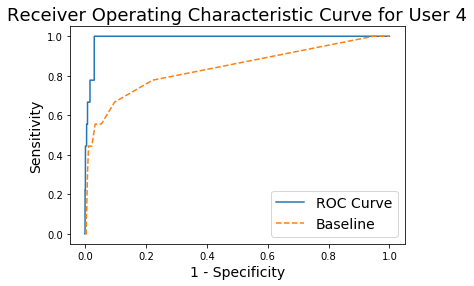

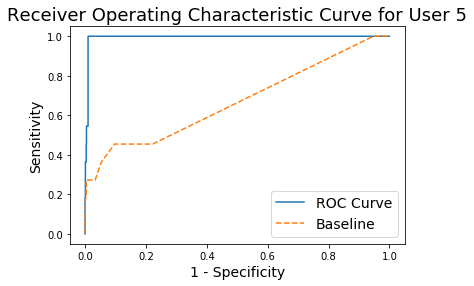

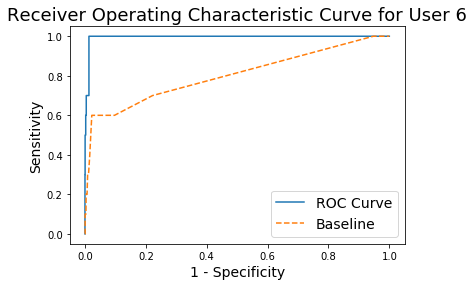

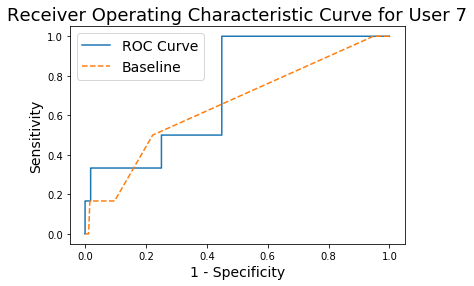

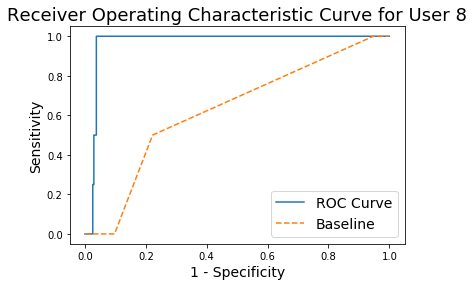

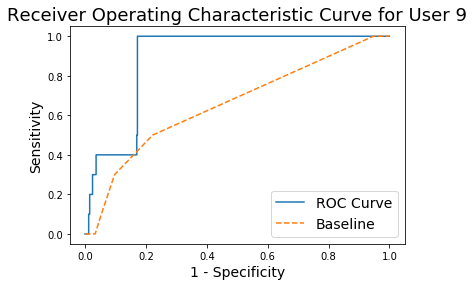

In [0]:
#plot ROC curve for all behavior types for first 10 users.
user = 0
for user in range(10):
  plot_roc(user, item_train_pv, item_users_altered_pv, [user_vecs_pv, item_vecs_pv.T], item_test_pv)
  user+=1

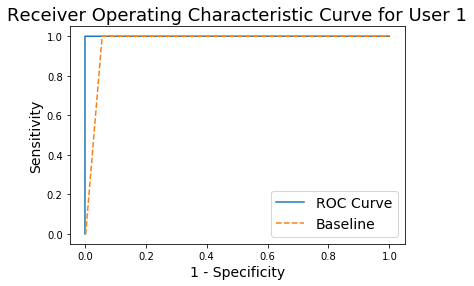

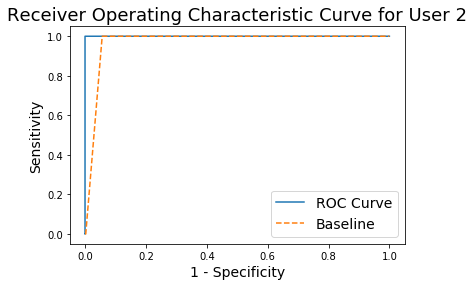

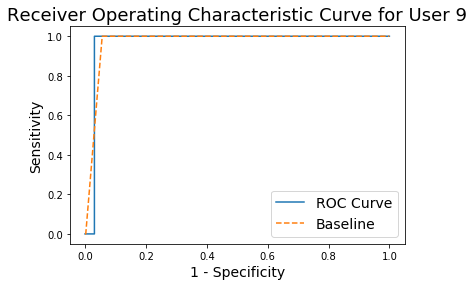

In [0]:
user = 0
for user in range(10):
  plot_roc(user, item_train_fav, item_users_altered_fav, [user_vecs_fav, item_vecs_fav.T], item_test_fav)
  user+=1

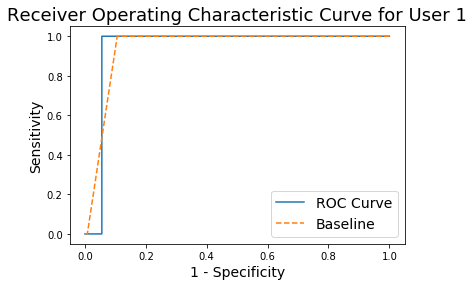

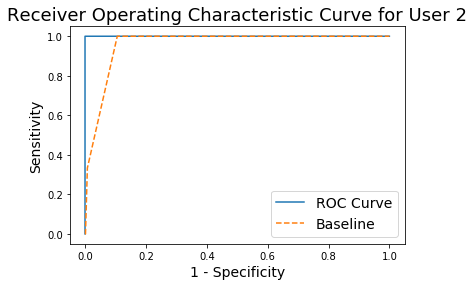

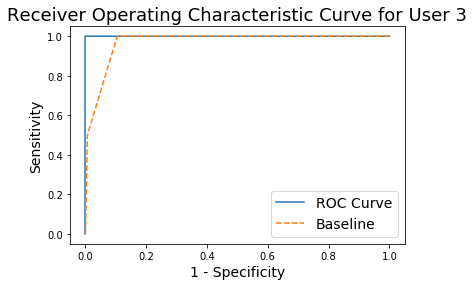

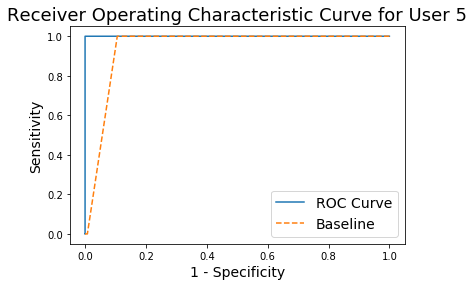

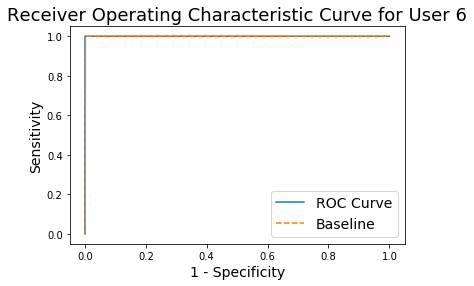

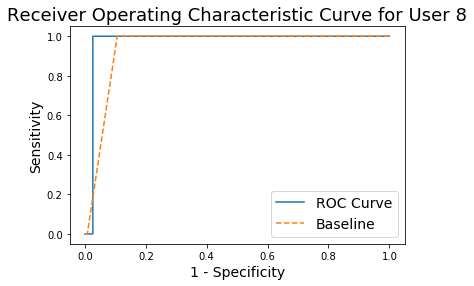

In [0]:
user = 0
for user in range(10):
  plot_roc(user, item_train_cart, item_users_altered_cart, [user_vecs_cart, item_vecs_cart.T], item_test_cart)
  user+=1

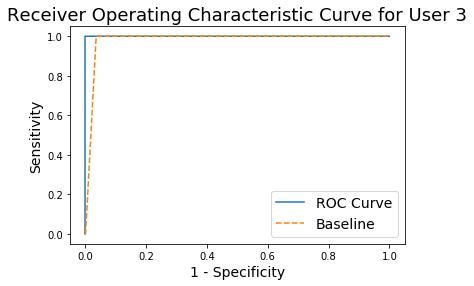

In [0]:
user = 0
for user in range(10):
  plot_roc(user, item_train_buy, item_users_altered_buy, [user_vecs_buy, item_vecs_buy.T], item_test_buy)
  user+=1

Graphical visualization of the ROC. From the graph above, the ROC curve is mostly above the baseline, which indicates that my model is fairly accurate.